# Predator–prey dynamics 


 > This chapter follows on from the [Competitive dynamics chapter](competitive-dynamics.ipynb) and applies the same analytical toolkit to **consumer–resource / predator–prey** interactions.
 >
 > We start with the classical Lotka–Volterra predator–prey model, then add increasingly realistic biology: harvesting (D’Ancona), prey self‑limitation, predator saturation (Holling type II), the Rosenzweig–MacArthur model, the paradox of enrichment, and a simple two‑patch spatial extension.
 >
 > References: {cite:t}`Lotka1925`; {cite:t}`Volterra1926`; {cite:t}`Holling1959`; {cite:t}`RosenzweigMacArthur1963`; {cite:t}`Rosenzweig1971`.

```{note} Conventions used here

- Prey (victim) density: $V(t)$
- Predator density: $P(t)$
- Time in arbitrary units unless stated.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals


---

## Lotka–Volterra predator–prey model

### Model and assumptions
The classical Lotka–Volterra (LV) predator–prey model is ({cite:t}`Lotka1925`; {cite:t}`Volterra1926`):

$$
\begin{aligned}
\dot V &= rV - aVP,\\
\dot P &= bVP - qP.
\end{aligned}
$$

Parameters:
- $r$: prey intrinsic growth rate (time$^{-1}$)
- $a$: attack (capture) rate (predator$^{-1}$ time$^{-1}$, depending on units of $V,P$)
- $b$: conversion efficiency (prey → predator births; dimensionless if $V,P$ share units)
- $q$: predator mortality rate (time$^{-1}$)

Key assumptions (non‑exhaustive):
- no prey density dependence
- linear (Type I) functional response
- no structure (age/space), no delays

A useful geometric tool is the **nullclines**:
- $\dot V=0 \Rightarrow P = r/a$ (for $V>0$)
- $\dot P=0 \Rightarrow V = q/b$ (for $P>0$)

Their intersection is the coexistence equilibrium.

In [2]:
def lv_rhs(t, y, r, a, b, q):
    V, P = y
    return [r*V - a*V*P, b*V*P - q*P]

def lv_nullclines(r, a, b, q):
    # returns (V* for predator nullcline, P* for prey nullcline)
    return q/b, r/a

def integrate(rhs, y0, t_end=50, args=(), n=2000):
    t_eval = np.linspace(0, t_end, n)
    sol = solve_ivp(lambda t,y: rhs(t,y,*args), (0, t_end), y0, t_eval=t_eval,
                    rtol=1e-9, atol=1e-12)
    return sol.t, sol.y


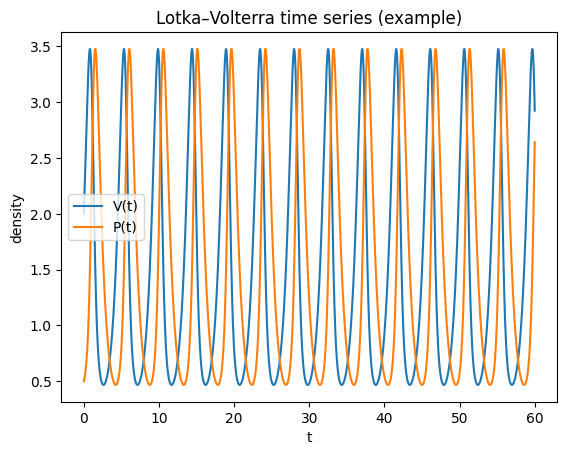

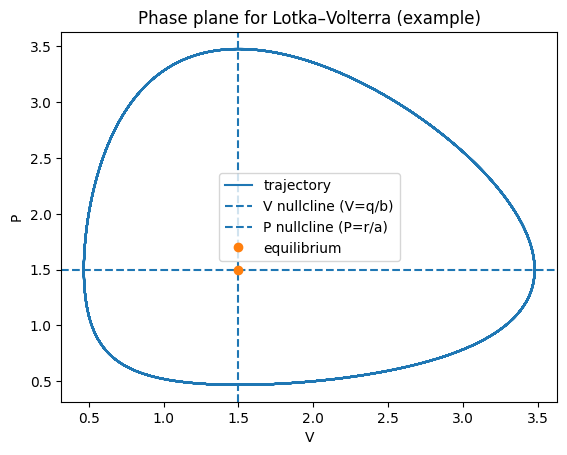

In [3]:
# Example LV simulation
r, a, b, q = 1.5, 1.0, 1.0, 1.5
V0, P0 = 2.0, 0.5
t, (V, P) = integrate(lv_rhs, [V0, P0], t_end=60, args=(r,a,b,q))

Vstar, Pstar = lv_nullclines(r,a,b,q)

plt.figure()
plt.plot(t, V, label="V(t)")
plt.plot(t, P, label="P(t)")
plt.xlabel("t"); plt.ylabel("density")
plt.title("Lotka–Volterra time series (example)")
plt.legend()
plt.show()

plt.figure()
plt.plot(V, P, label="trajectory")
plt.axvline(Vstar, linestyle="--", label="V nullcline (V=q/b)")
plt.axhline(Pstar, linestyle="--", label="P nullcline (P=r/a)")
plt.plot([Vstar],[Pstar], marker="o", linestyle="none", label="equilibrium")
plt.xlabel("V"); plt.ylabel("P")
plt.title("Phase plane for Lotka–Volterra (example)")
plt.legend()
plt.show()


### Equilibria and (non‑)robustness
The coexistence equilibrium is

$$
(V^*,P^*) = \left(\frac{q}{b},\frac{r}{a}\right).
$$

Linearising about $(V^*,P^*)$ gives purely imaginary eigenvalues in the classical LV model (a neutrally stable centre).
Consequently:
- trajectories form closed orbits
- oscillation amplitude depends on initial conditions
- small model changes can make the equilibrium stable (damped oscillations) or unstable (growing oscillations)

This motivates adding more realistic processes: prey self‑limitation, predator saturation, space, etc.


## LV with fishing (D’Ancona)

A simple way to represent fisheries is to add proportional harvesting to both populations:

$$
\begin{aligned}
\dot V &= rV - aVP - fV,\\
\dot P &= bVP - qP - fP.
\end{aligned}
$$

Nullclines:
- $\dot V=0 \Rightarrow P = (r-f)/a$
- $\dot P=0 \Rightarrow V = (q+f)/b$

So fishing shifts the coexistence equilibrium to

$$
(V^*,P^*) = \left(\frac{q+f}{b},\frac{r-f}{a}\right),
$$

as long as $r>f$ (otherwise predators cannot persist).

**Interpretation (D’Ancona):** If fishing pressure drops (smaller $f$), predators increase and prey decrease at equilibrium.


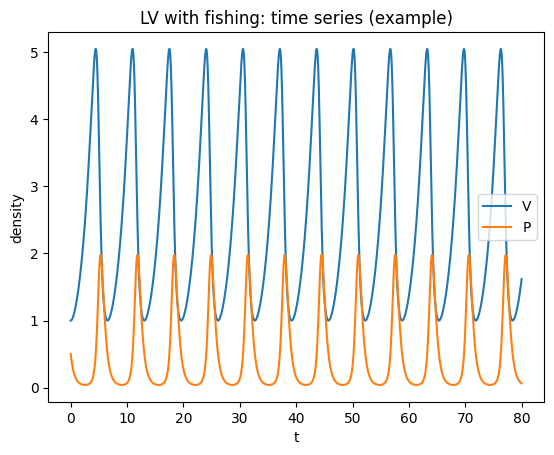

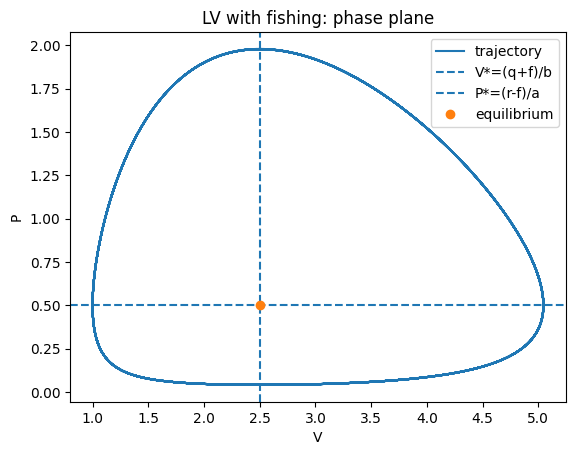

In [4]:
def lv_fish_rhs(t, y, r, a, b, q, f):
    V, P = y
    return [(r-f)*V - a*V*P, b*V*P - (q+f)*P]

def fish_equilibrium(r,a,b,q,f):
    return (q+f)/b, (r-f)/a

r,a,b,q,f = 1.5,1,1,1.5,1.0
t,(V,P)=integrate(lv_fish_rhs,[1.0,0.5],t_end=80,args=(r,a,b,q,f))
Vstar,Pstar = fish_equilibrium(r,a,b,q,f)

plt.figure()
plt.plot(t,V,label="V")
plt.plot(t,P,label="P")
plt.xlabel("t"); plt.ylabel("density")
plt.title("LV with fishing: time series (example)")
plt.legend(); plt.show()

plt.figure()
plt.plot(V,P,label="trajectory")
plt.axvline(Vstar,linestyle="--",label="V*=(q+f)/b")
plt.axhline(Pstar,linestyle="--",label="P*=(r-f)/a")
plt.plot([Vstar],[Pstar],marker="o",linestyle="none",label="equilibrium")
plt.xlabel("V"); plt.ylabel("P")
plt.title("LV with fishing: phase plane")
plt.legend(); plt.show()


## Prey density dependence (logistic prey)

Add prey self‑limitation by replacing prey growth with logistic growth:

$$
\begin{aligned}
\dot V &= rV\left(1-\frac{V}{K}\right) - aVP,\\
\dot P &= bVP - qP.
\end{aligned}
$$

This tends to **stabilise** the dynamics relative to classical LV.
There are two biologically relevant equilibria:
1) predator extinction: $(V,P)=(K,0)$  
2) coexistence (if feasible): $V^*=q/b$, $P^*=\frac{r}{a}\left(1-\frac{q}{bK}\right)$

Feasibility requires $K>q/b$.


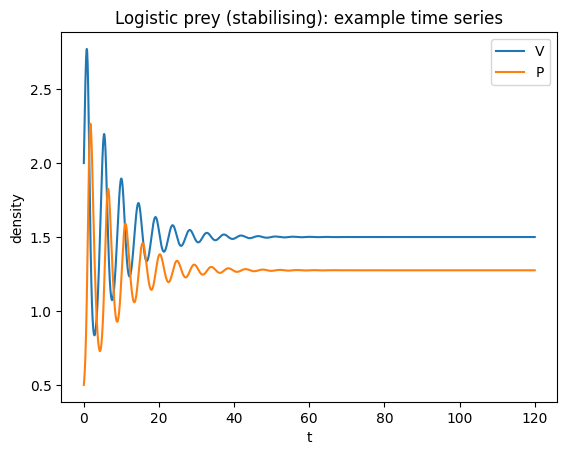

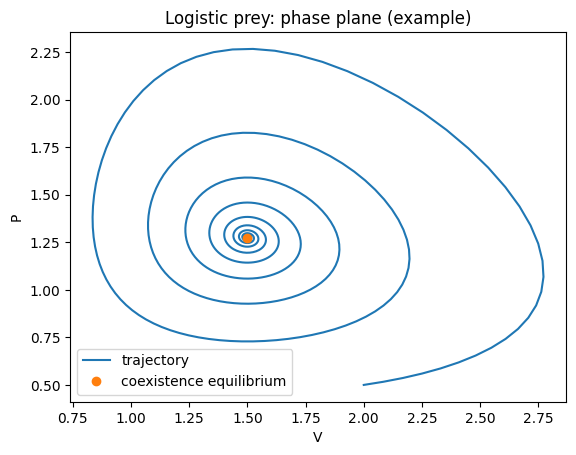

In [5]:
def lv_logistic_rhs(t, y, r, K, a, b, q):
    V, P = y
    return [r*V*(1 - V/K) - a*V*P, b*V*P - q*P]

def coexist_eq_logistic(r,K,a,b,q):
    Vstar = q/b
    Pstar = (r/a)*(1 - Vstar/K)
    return Vstar, Pstar

r,K,a,b,q = 1.5, 10.0, 1.0, 1.0, 1.5
t,(V,P) = integrate(lv_logistic_rhs,[2.0,0.5],t_end=120,args=(r,K,a,b,q))
Vstar,Pstar = coexist_eq_logistic(r,K,a,b,q)

plt.figure()
plt.plot(t,V,label="V")
plt.plot(t,P,label="P")
plt.xlabel("t"); plt.ylabel("density")
plt.title("Logistic prey (stabilising): example time series")
plt.legend(); plt.show()

plt.figure()
plt.plot(V,P,label="trajectory")
plt.plot([Vstar],[Pstar],marker="o",linestyle="none",label="coexistence equilibrium")
plt.xlabel("V"); plt.ylabel("P")
plt.title("Logistic prey: phase plane (example)")
plt.legend(); plt.show()


## Holling type II response and the Rosenzweig–MacArthur model

Predators may saturate at high prey density due to handling time $h$.
Holling type II functional response replaces $aV$ by:

$$
\frac{aV}{1+ahV}.
$$

A standard predator–prey model combining logistic prey growth and Holling II is the **Rosenzweig–MacArthur (R–M)** model:

$$
\begin{aligned}
\dot V &= rV\left(1-\frac{V}{K}\right) - \frac{aVP}{1+ahV},\\
\dot P &= b\frac{aVP}{1+ahV} - qP.
\end{aligned}
$$

For small/moderate $K$, the coexistence equilibrium is stable; for larger $K$ it can lose stability in a **Hopf bifurcation**, producing a stable **limit cycle**.

This gives the **paradox of enrichment**: increasing $K$ (making the prey’s environment richer) can destabilise the system and increase oscillation amplitude, raising extinction risk in realistic settings.


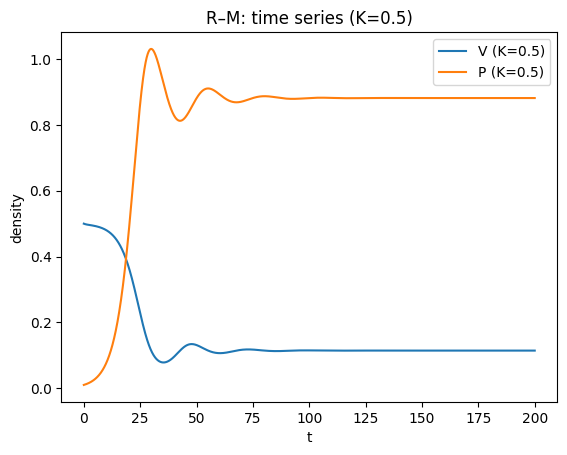

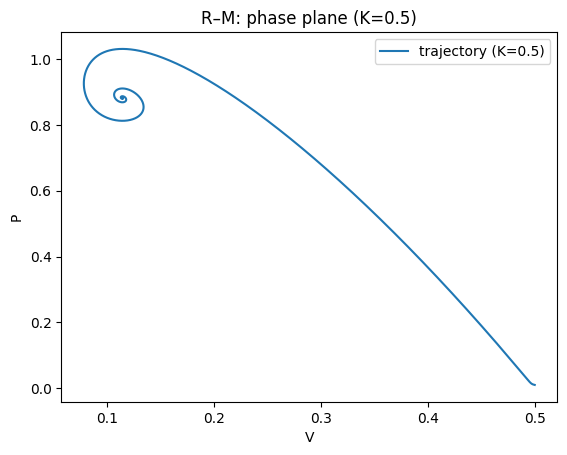

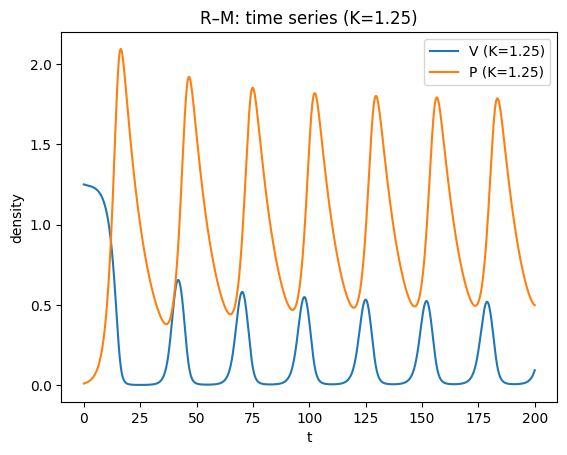

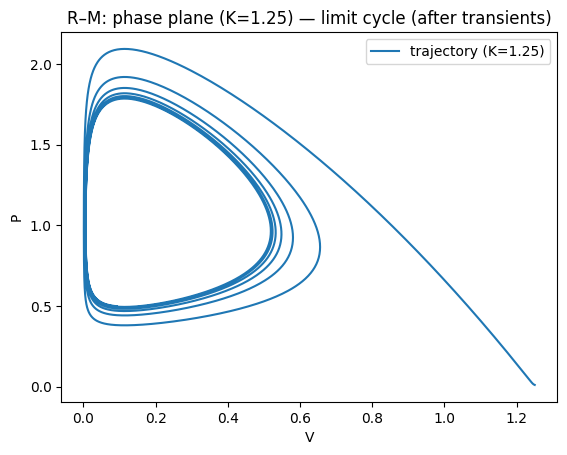

In [6]:
def rm_rhs(t, y, r, K, a, h, b, q):
    V, P = y
    pred = (a*V*P)/(1 + a*h*V)
    return [r*V*(1 - V/K) - pred, b*pred - q*P]

def simulate_rm(K, a=1, b=1, h=1.25, q=0.1, r=1.0, y0=(0.5,0.01), t_end=200):
    t_eval = np.linspace(0, t_end, 6000)
    sol = solve_ivp(lambda t,y: rm_rhs(t,y,r,K,a,h,b,q), (0,t_end), list(y0),
                    t_eval=t_eval, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y

# Compare two K values (used again in practical)
t1,(V1,P1)=simulate_rm(K=0.5, y0=(0.5,0.01), t_end=200)
t2,(V2,P2)=simulate_rm(K=1.25, y0=(1.25,0.01), t_end=200)

plt.figure()
plt.plot(t1,V1,label="V (K=0.5)")
plt.plot(t1,P1,label="P (K=0.5)")
plt.xlabel("t"); plt.ylabel("density")
plt.title("R–M: time series (K=0.5)")
plt.legend(); plt.show()

plt.figure()
plt.plot(V1,P1,label="trajectory (K=0.5)")
plt.xlabel("V"); plt.ylabel("P")
plt.title("R–M: phase plane (K=0.5)")
plt.legend(); plt.show()

plt.figure()
plt.plot(t2,V2,label="V (K=1.25)")
plt.plot(t2,P2,label="P (K=1.25)")
plt.xlabel("t"); plt.ylabel("density")
plt.title("R–M: time series (K=1.25)")
plt.legend(); plt.show()

plt.figure()
plt.plot(V2,P2,label="trajectory (K=1.25)")
plt.xlabel("V"); plt.ylabel("P")
plt.title("R–M: phase plane (K=1.25) — limit cycle (after transients)")
plt.legend(); plt.show()


### A simple numerical “bifurcation diagram” in $K$

We can emulate a 1‑parameter bifurcation diagram by:
1) choosing a grid of $K$ values
2) integrating long enough for transients to decay
3) sampling the long‑run prey values

If the dynamics converge to equilibrium, points collapse to a line.
If a stable limit cycle exists, points fill out the range between cycle minima and maxima.


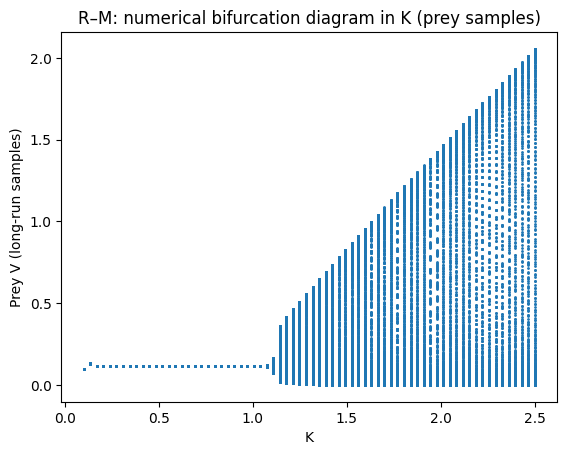

In [7]:
def rm_bifurcation_points(K_values, a=1, b=1, h=1.25, q=0.1, r=1.0,
                          burn=400, sample=200, step=0.2, y0=(0.2,0.01)):
    Ks=[]
    Vs=[]
    # continuation-like: reuse final state as next initial condition for numerical stability
    y=list(y0)
    for K in K_values:
        t_end = burn + sample
        t_eval = np.arange(0, t_end+step, step)
        sol = solve_ivp(lambda t,yy: rm_rhs(t,yy,r,K,a,h,b,q),
                        (0,t_end), y, t_eval=t_eval, rtol=1e-8, atol=1e-10)
        V = sol.y[0]
        y = [sol.y[0,-1], sol.y[1,-1]]
        # collect points from last 'sample' time
        mask = sol.t >= burn
        Ks.extend([K]*np.sum(mask))
        Vs.extend(list(V[mask]))
    return np.array(Ks), np.array(Vs)

Kvals = np.linspace(0.1, 2.5, 70)
Ks, Vs = rm_bifurcation_points(Kvals)

plt.figure()
plt.plot(Ks, Vs, marker=".", linestyle="none", markersize=2)
plt.xlabel("K"); plt.ylabel("Prey V (long-run samples)")
plt.title("R–M: numerical bifurcation diagram in K (prey samples)")
plt.show()


## Space: two coupled patches

A minimal spatial extension is to couple two identical patches with predator dispersal:

Patch $i$ has $(V_i,P_i)$ following R–M dynamics; predators disperse at rate $d$:

$$
\begin{aligned}
\dot P_1 &= \text{local dynamics} + d(P_2-P_1),\\
\dot P_2 &= \text{local dynamics} + d(P_1-P_2).
\end{aligned}
$$

This is a 4D system. We typically visualise:
- time series of totals ($V_1+V_2$, $P_1+P_2$)
- a 2D projection, e.g. $(V_1,P_1)$ or $(V_1+V_2, P_1+P_2)$
- sometimes log‑totals to show behavior near very small values


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2805998185277D+03   r2 =                  NaN


/tmp/ipykernel_104249/1283358586.py:3: RuntimeWarning: overflow encountered in scalar multiply
  pred1 = (a*V1*P1)/(1 + a*h*V1)
/tmp/ipykernel_104249/1283358586.py:4: RuntimeWarning: overflow encountered in scalar multiply
  pred2 = (a*V2*P2)/(1 + a*h*V2)
/home/mhasoba/Documents/Teaching/MulQuaBio/MQB/.venv/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


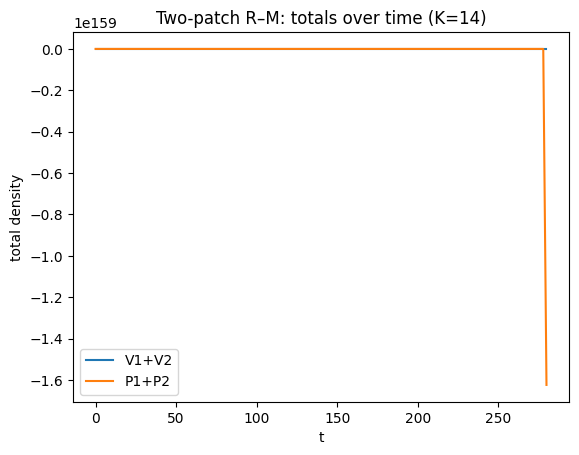

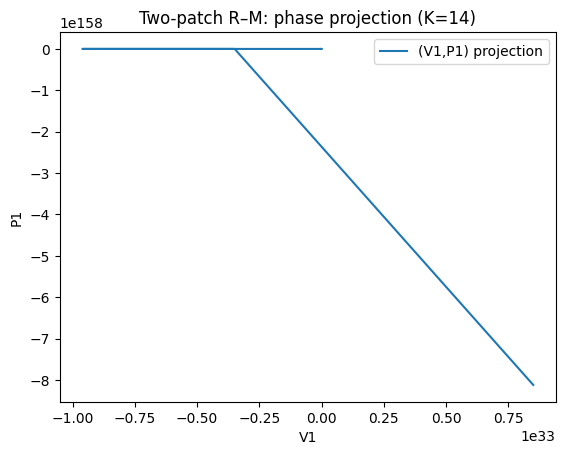

In [8]:
def rm2patch_rhs(t, y, r, K, a, h, b, q, d):
    V1, P1, V2, P2 = y
    pred1 = (a*V1*P1)/(1 + a*h*V1)
    pred2 = (a*V2*P2)/(1 + a*h*V2)
    dV1 = r*V1*(1 - V1/K) - pred1
    dV2 = r*V2*(1 - V2/K) - pred2
    dP1 = b*pred1 - q*P1 + d*(P2-P1)
    dP2 = b*pred2 - q*P2 + d*(P1-P2)
    return [dV1, dP1, dV2, dP2]

def simulate_rm2(K, d=0.42, h=0.1, a=1, b=1, q=1, r=0.05,
                 y0=(None, 0.01, None, 0.02), t_end=300, step=2.0,
                 method="LSODA", rtol=1e-6, atol=1e-9):
    if y0[0] is None or y0[2] is None:
        y0 = (K, y0[1], K, y0[3])
    t_eval = np.arange(0, t_end + step, step)
    sol = solve_ivp(
        lambda t, y: rm2patch_rhs(t, y, r, K, a, h, b, q, d),
        (0, t_end), list(y0), t_eval=t_eval, method=method, rtol=rtol, atol=atol,
    )
    return sol.t, sol.y

# A quick illustration at moderate K (kept short for fast book builds)
t, (V1, P1, V2, P2) = simulate_rm2(K=14, t_end=300, step=2.0)
Vtot = V1 + V2
Ptot = P1 + P2

plt.figure()
plt.plot(t, Vtot, label="V1+V2")
plt.plot(t, Ptot, label="P1+P2")
plt.xlabel("t"); plt.ylabel("total density")
plt.title("Two-patch R–M: totals over time (K=14)")
plt.legend(); plt.show()

plt.figure()
plt.plot(V1, P1, label="(V1,P1) projection")
plt.xlabel("V1"); plt.ylabel("P1")
plt.title("Two-patch R–M: phase projection (K=14)")
plt.legend(); plt.show()


---

## Summary
- The Lotka–Volterra predator–prey model produces neutrally stable cycles around a coexistence equilibrium; oscillation amplitude depends on initial conditions, so small model changes can qualitatively change stability.
- Adding harvesting shifts nullclines and the coexistence equilibrium; in the simple symmetric-harvest form, lowering fishing pressure increases predators and decreases prey at equilibrium (D’Ancona-style effect).
- Prey self-limitation (logistic growth) and predator saturation (Holling type II) are biologically motivated mechanisms that often stabilise dynamics at low enrichment, but can also generate stable limit cycles via a Hopf bifurcation (Rosenzweig–MacArthur).
- The paradox of enrichment highlights that increasing prey carrying capacity $K$ can destabilise consumer–resource dynamics, increasing oscillation amplitude and (in realistic settings) extinction risk.
- Spatial structure (e.g. two coupled patches with dispersal) can change outcomes by desynchronising dynamics across space and buffering local crashes.